### Comparing the Color of Lenses

Jenny Kim, Phil Marshall

The OM10 mock lensed quasar catalog `qso_mock.fits` contains estimates of the lens galaxy $i$-band magnitudes, based on a simple Faber-Jackson scaling implemented by Phil Marshall. With the `lenspop` library we can compute synthetic magnitudes in any filter. In this notebook, we will look at the differences in the distributions of the 1) redshift, 2) $i$-band magnitude, 3) $g-r$ magnitude, 4) $r-i$ magnitude, and 5) $i-z$ magnitude between the known SDSS values and the colored magnitudes for each lens by drawing a cornerplot.

### Requirements

`om10`, `qso_mock.fits`, and `om10`'s dependencies:

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from __future__ import division
import os, numpy as np
import corner
import om10
from om10 import plotting
from astropy.table import Table
import matplotlib

First, let's read the catalog and select 200 lenses whose magnitudes are smaller than 23.6. Then, let's paint the lenses.

In [9]:
%%capture
db = om10.DB(catalog='/Users/Jenny/Desktop/om10fork/om10/data/qso_mock.fits')
db.select_random(Nlens=200,maglim=20.0)
db.paint(synthetic=True, target='lens')

`db.paint` method takes a while to compute the magnitude of 200 lenses. Thus, if we want, we can save the file by using the method:

`db.write_table('/Users/Jenny/Desktop/om10fork/om10/data/qso_sample_lens_colored.fits')`

and next time, when we are reusing the data, we can call :

`db = om10.DB(catalog='/Users/Jenny/Desktop/om10fork/om10/data/qso_sample_lens_colored.fits').`

After finishing the cross-checking with various different data sets, we can override `qso_mock.fits` with six more columns - u, g, r, i, z, and y.

Read the real data of lenses from the `../data/SDSS_LRGs.txt` file. `../data/SDSS_LRGs.txt` has the following columns : `ra  dec  z  mag_u  mag_g  mag_r  mag_i  mag_z`.

In [14]:
table = np.loadtxt('../data/SDSS_LRGs.txt')
zReal = table[:,2]
iReal = table[:,6]
grReal = table[:,4]-table[:,5]
riReal = table[:,5]-table[:,6]
izReal = table[:,6]-table[:,7]

Then, we need to weight the mocked lenses with respect to the parent population. The parent population would be gaussian distributed, and the mean would be given by $np.mean(z)$ and the standard deviation would be given by $np.std(z)$.

The weight could first be calculated by using this formula:

$$\frac { P(redshift) }{ Q(redshift) } $$

where P(redshift) is a y-value of redshift in the parent normal distribution and Q(redshift) is a y-value of redshift in the mock, colored lenses. 

In addition to this, we can use rejection sampling method to make the distribution more like its gaussian population distribution.

Reweighting algorithm is implemented in `gaussian_reweight`.

In [11]:
db.gaussian_reweight(np.mean(z), np.std(z))
matplotlib.rc('text', usetex=False)
# calculate the color index for g-r, r-i, and i-z
gr = db.sample['g_SDSS'] - db.sample['r_SDSS']
ri = db.sample['r_SDSS'] - db.sample['i_SDSS']
iz = db.sample['i_SDSS'] - db.sample['z_SDSS']

Then, we draw the cornerplot with the synthetically colored OM10 lenses and save to the argument `fig1`.  Then, we will overlap the synthetically colored samples with the original data. Ideally, the distributions of the data should look similar, and the blue contours and the red contours should have significant overlap.

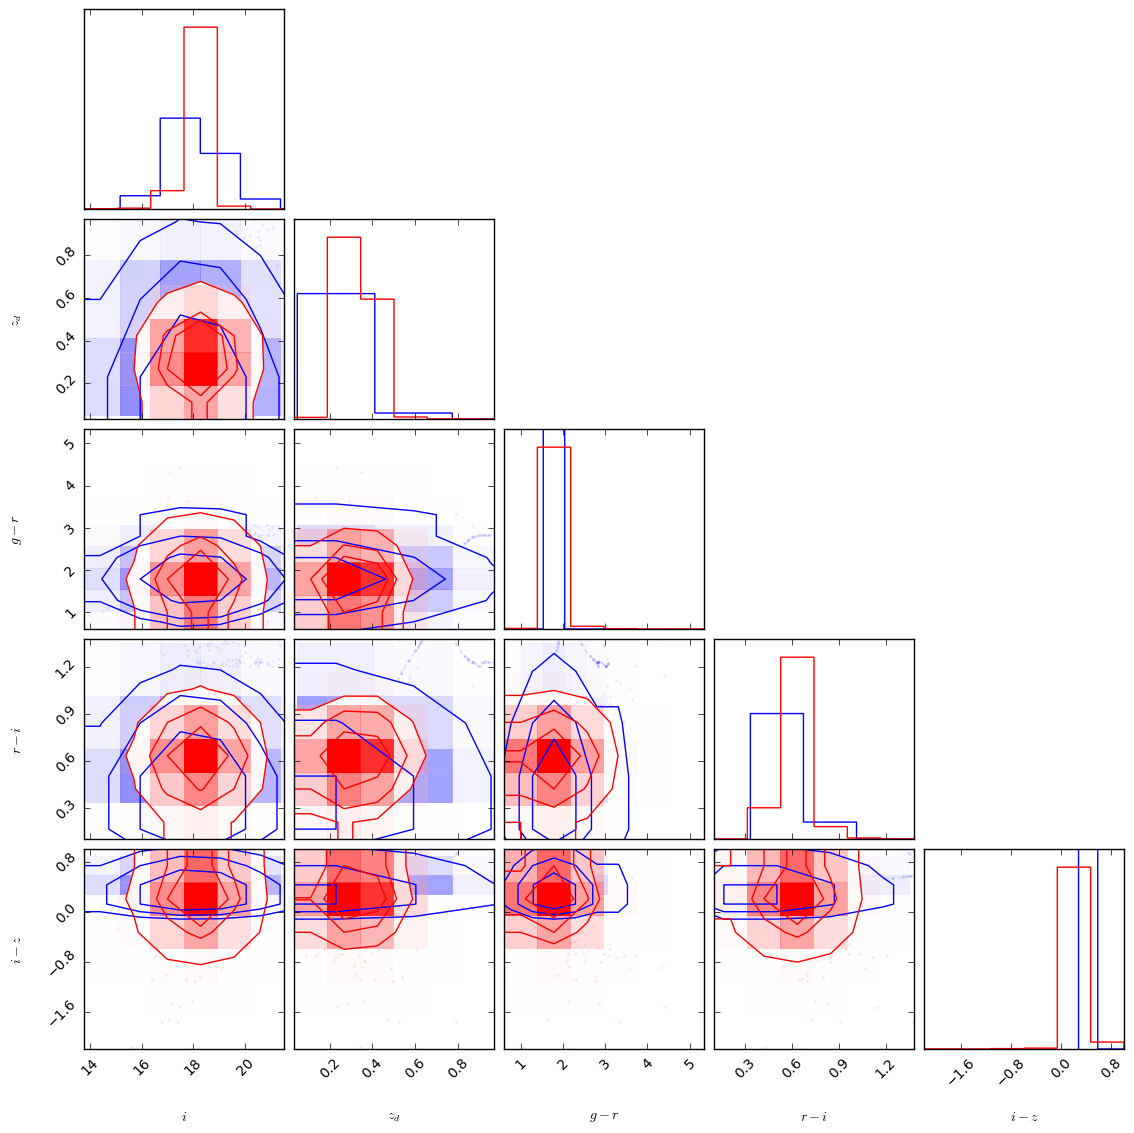

In [12]:
# save the syntheticall colored OM10 lenses' cornerplot to fig1
data = Table({'i_SDSS': db.sample['i_SDSS'], 'ZLENS': db.sample['ZLENS'], 'GR': gr, 'RI': ri, 'IZ': iz}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
fig1 = corner.corner(features, labels=labels, color='blue', weights=db.sample['weight'], smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))

#overlap fig1 with the real distribution
data = Table({'i_SDSS': iReal, 'ZLENS': zReal, 'GR': grReal, 'RI': riReal, 'IZ': izReal}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.0, fig=fig1, hist_kwargs=dict(normed=True), hist2d_kwarge=dict(alpha=0.5))

### Discussion

Red(the real data) and the blue(synthetically colored data) contours look really similar to each other. This suggests the synthetic coloring of OM10 lenses are indeed returning correct magnitudes.